Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [3]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
# Defining the path for train and test images
# Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Skin cancer/Test')

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## Train dataset
train_ds =  tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

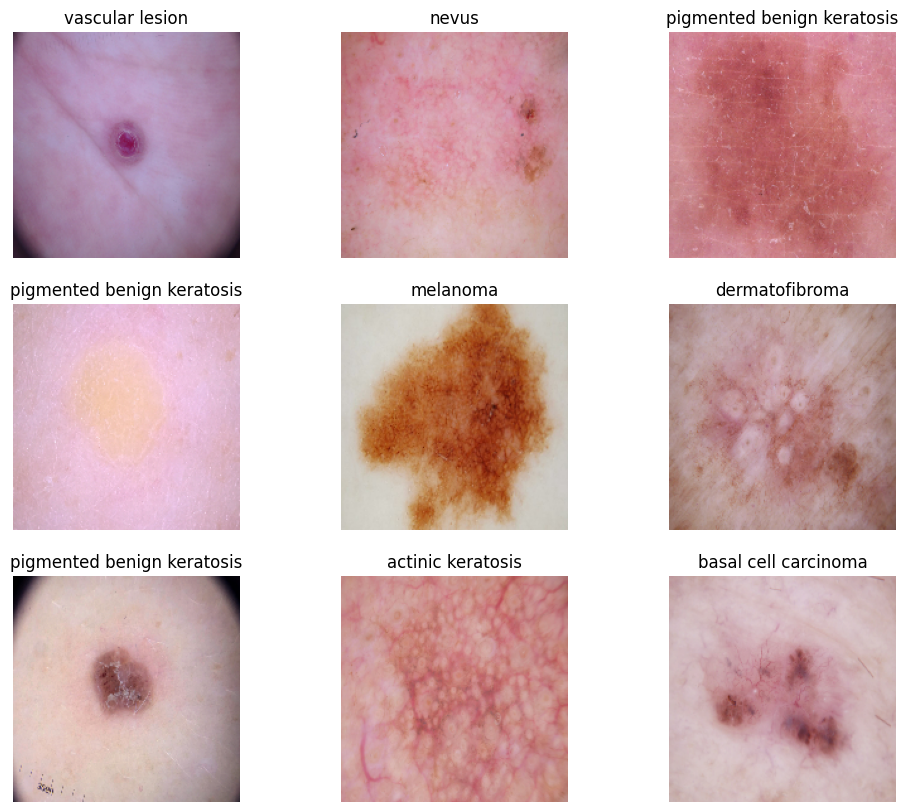

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [14]:
### choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                   

### Train the model

In [16]:
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 199s 927ms/step - loss: 2.0623 - accuracy: 0.1886 - val_loss: 2.0327 - val_accuracy: 0.2058
Epoch 2/30
56/56 [==============================] - 5s 91ms/step - loss: 2.0371 - accuracy: 0.1981 - val_loss: 2.0232 - val_accuracy: 0.2148
Epoch 3/30
56/56 [==============================] - 5s 89ms/step - loss: 2.0207 - accuracy: 0.2059 - val_loss: 2.0136 - val_accuracy: 0.1991
Epoch 4/30
56/56 [==============================] - 5s 90ms/step - loss: 1.9971 - accuracy: 0.2338 - val_loss: 1.9528 - val_accuracy: 0.2864
Epoch 5/30
56/56 [==============================] - 5s 88ms/step - loss: 1.9332 - accuracy: 0.2773 - val_loss: 1.8958 - val_accuracy: 0.2886
Epoch 6/30
56/56 [==============================] - 5s 89ms/step - loss: 1.8580 - accuracy: 0.2952 - val_loss: 1.8877 - val_accuracy: 0.2774
Epoch 7/30
56/56 [==============================] - 5s 90ms/step - loss: 1.8657 - accuracy: 0.2952 - val_loss: 1.7906 - val_accuracy: 0.3423
Epoch 8/30
56/56 [===

### Visualizing training results

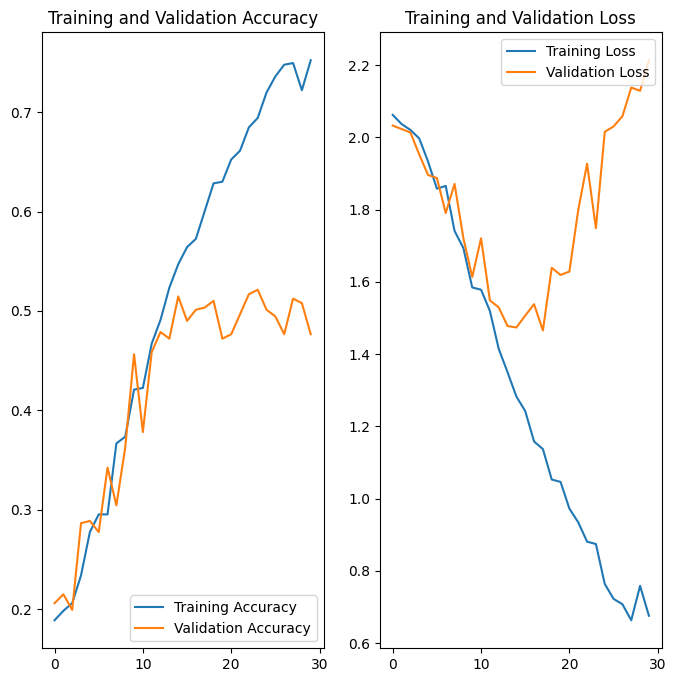

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Findings

### the model is overfitting the train accuracy is 90% and the validation accuracy is only 52%
### One of the reasons of overfitting could be lack of sufficient images as we know that CNN model require huge amount of images to learn, hence it looks like the model is memorizing the train images and therefore leading to overfitting

In [18]:
# data augmentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical",input_shape=(img_height,img_width,3)),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1)
])

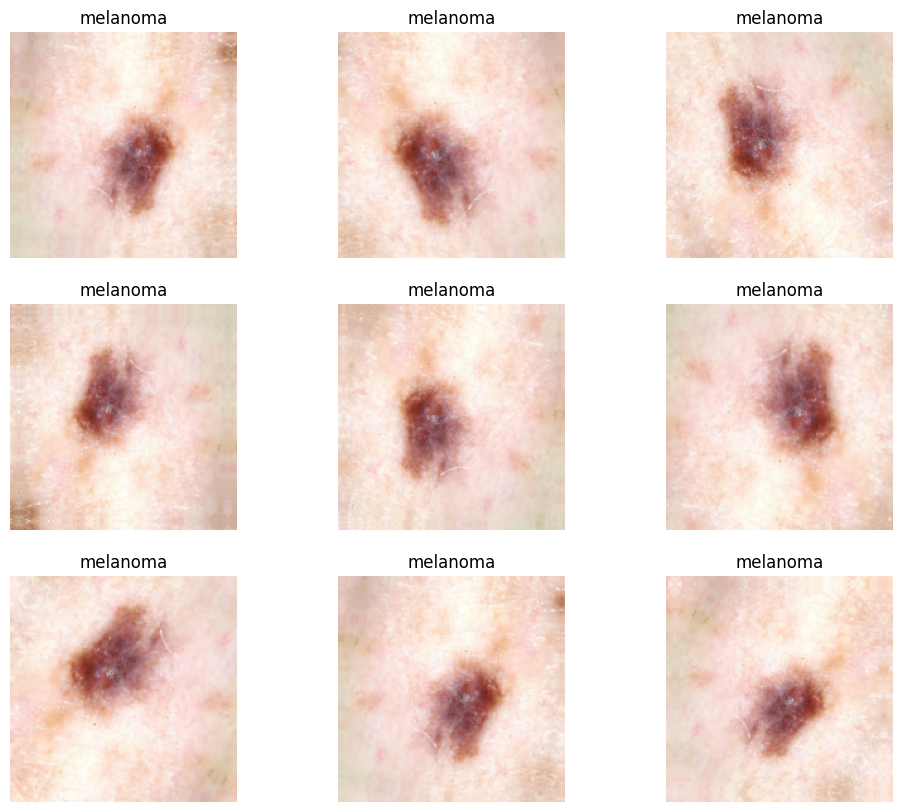

In [19]:
# visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(12, 10))
for images, labels in train_ds.take(1):
    for i in range(num_classes):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[labels[0]])
        plt.axis("off")
plt.show()

### Create the model, compile and train the model


In [20]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
model = Sequential([
    # data augmentation layer
  data_augmentation,
    # Rescaling layer
  layers.experimental.preprocessing.Rescaling(1./255),
    # 1st conv layer
  layers.Conv2D(16, 3, padding='same', activation='relu'),
    # maxpoolig layer
  layers.MaxPooling2D(),
    # 2nd conv layer
  layers.Conv2D(32, 3, padding='same', activation='relu'),
    # maxpooling layer
  layers.MaxPooling2D(),
    # 3rd conv layer
  layers.Conv2D(64, 3, padding='same', activation='relu'),
    # maxpooling layer
  layers.MaxPooling2D(),
    # flatten
  layers.Flatten(),
    # 1st dense layer
  layers.Dense(128, activation='relu'),
    # output layer
  layers.Dense(num_classes,activation='softmax')
])


### Compiling the model

In [21]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [22]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 6s 29ms/step - loss: 2.0775 - accuracy: 0.2483 - val_loss: 1.9745 - val_accuracy: 0.2349
Epoch 2/20
56/56 [==============================] - 1s 22ms/step - loss: 1.8841 - accuracy: 0.2863 - val_loss: 1.8284 - val_accuracy: 0.3087
Epoch 3/20
56/56 [==============================] - 1s 22ms/step - loss: 1.6602 - accuracy: 0.3940 - val_loss: 1.5877 - val_accuracy: 0.4183
Epoch 4/20
56/56 [==============================] - 1s 22ms/step - loss: 1.5571 - accuracy: 0.4358 - val_loss: 1.5928 - val_accuracy: 0.4519
Epoch 5/20
56/56 [==============================] - 1s 22ms/step - loss: 1.4748 - accuracy: 0.4771 - val_loss: 1.4502 - val_accuracy: 0.4653
Epoch 6/20
56/56 [==============================] - 1s 22ms/step - loss: 1.3970 - accuracy: 0.5011 - val_loss: 1.4494 - val_accuracy: 0.4743
Epoch 7/20
56/56 [==============================] - 1s 22ms/step - loss: 1.3599 - accuracy: 0.5100 - val_loss: 1.3824 - val_accuracy: 0.5213
Epoch 8/20
56

### Visualizing the results

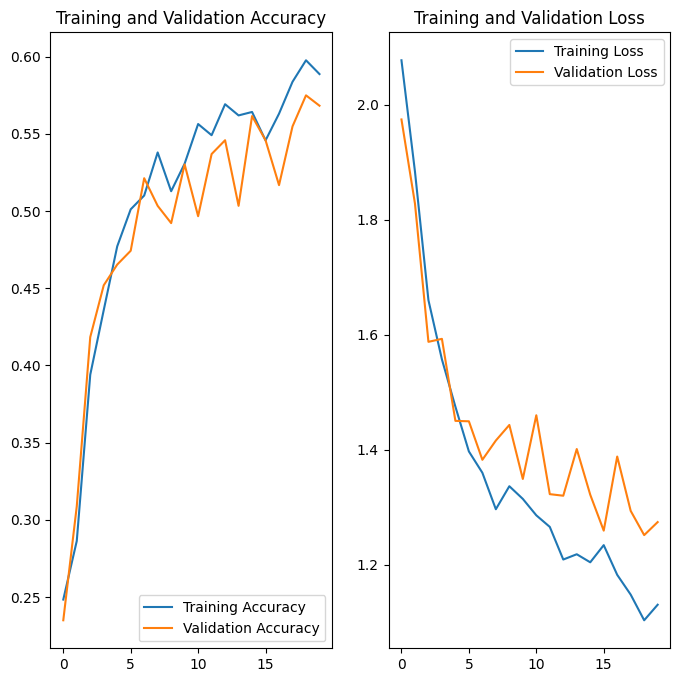

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Findings
There is no improvement in accuracy but we can definitely see the overfitting problem has solved due to data augmentation

We can increase the epochs to increase the accuracy so it's too early for judgement

#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [24]:
path_list=[]
lesion_list=[]
for i in class_names:

    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/Skin cancer/Train/acti...,actinic keratosis
1,/content/gdrive/MyDrive/Skin cancer/Train/acti...,actinic keratosis
2,/content/gdrive/MyDrive/Skin cancer/Train/acti...,actinic keratosis
3,/content/gdrive/MyDrive/Skin cancer/Train/acti...,actinic keratosis
4,/content/gdrive/MyDrive/Skin cancer/Train/acti...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/Skin cancer/Train/vasc...,vascular lesion
2235,/content/gdrive/MyDrive/Skin cancer/Train/vasc...,vascular lesion
2236,/content/gdrive/MyDrive/Skin cancer/Train/vasc...,vascular lesion
2237,/content/gdrive/MyDrive/Skin cancer/Train/vasc...,vascular lesion


In [26]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/Skin cancer/Train/acti...,actinic keratosis
1,/content/gdrive/MyDrive/Skin cancer/Train/acti...,actinic keratosis
2,/content/gdrive/MyDrive/Skin cancer/Train/acti...,actinic keratosis
3,/content/gdrive/MyDrive/Skin cancer/Train/acti...,actinic keratosis
4,/content/gdrive/MyDrive/Skin cancer/Train/acti...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/Skin cancer/Train/vasc...,vascular lesion
2235,/content/gdrive/MyDrive/Skin cancer/Train/vasc...,vascular lesion
2236,/content/gdrive/MyDrive/Skin cancer/Train/vasc...,vascular lesion
2237,/content/gdrive/MyDrive/Skin cancer/Train/vasc...,vascular lesion


<BarContainer object of 9 artists>

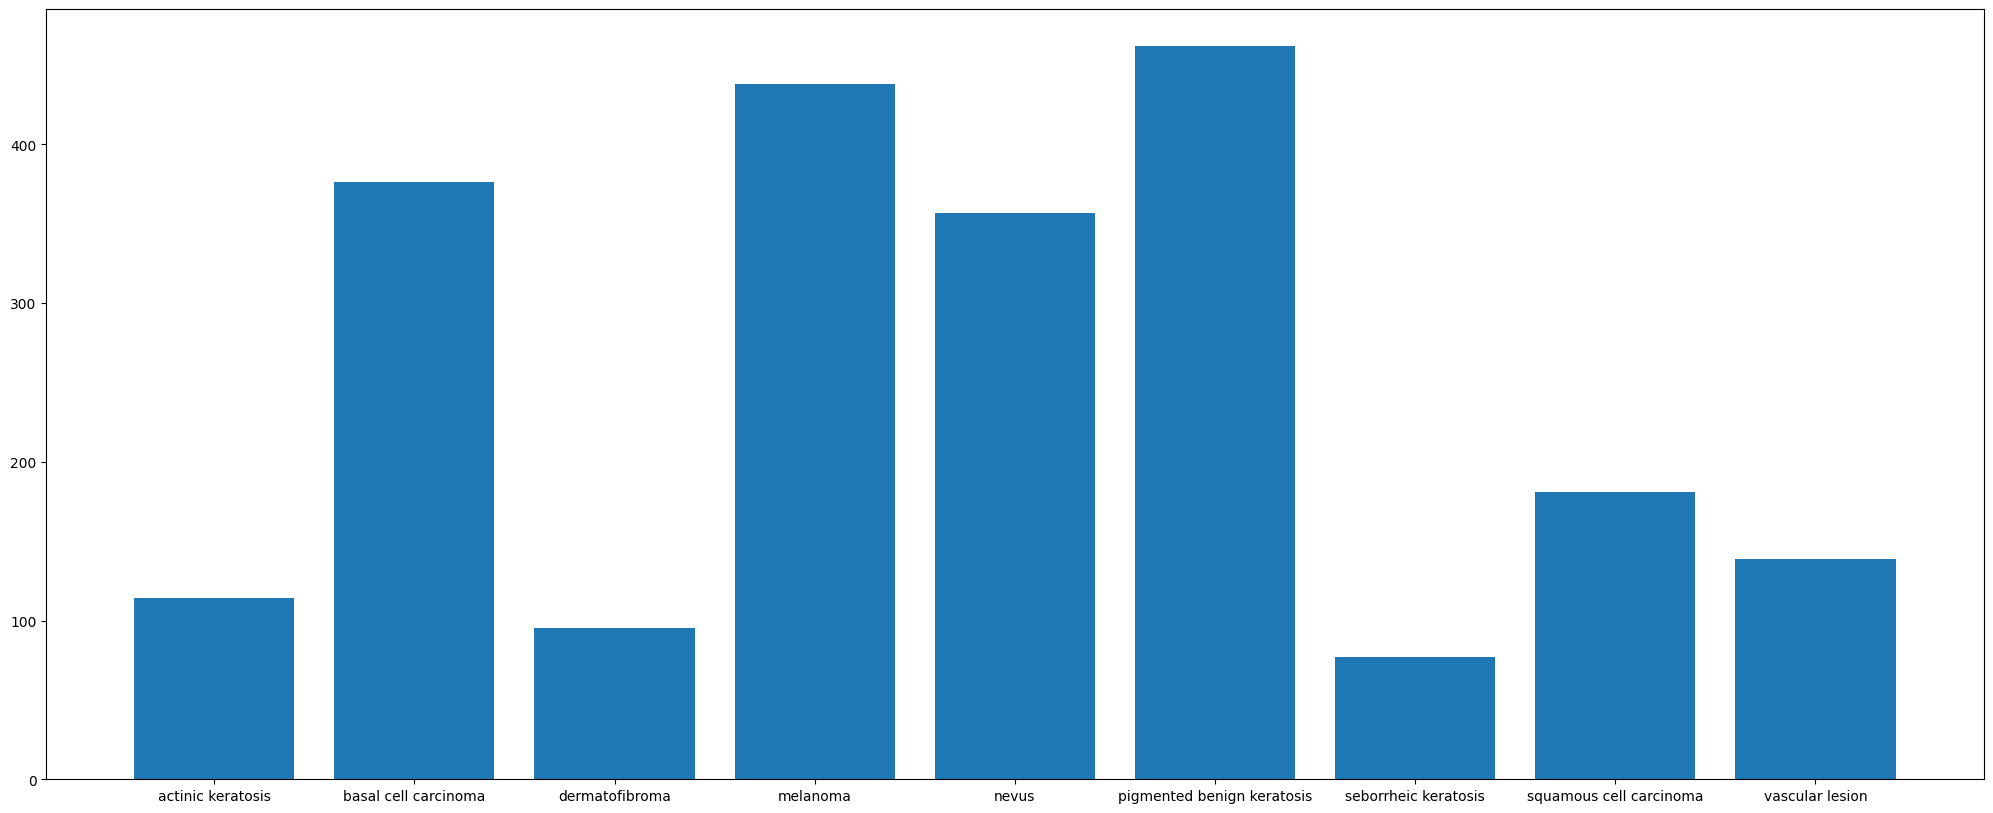

In [25]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

#### Findings here:
 squamous cell carcinoma has least number of samples

actinic keratosis and dermatofibroma have proportionate number of classes.
melanoma and pigmented benign keratosis have proprtionate number of classes

#### Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [27]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [30]:
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline("/content/gdrive/MyDrive/Skin cancer/Train",save_format='jpg')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F4C40166C20>: 100%|██████████| 500/500 [00:38<00:00, 13.06 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4BCC34FC40>: 100%|██████████| 500/500 [00:50<00:00,  9.94 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4BD3C51510>: 100%|██████████| 500/500 [00:44<00:00, 11.34 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F4BCCDA91B0>: 100%|██████████| 500/500 [00:45<00:00, 10.89 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4BCCD7BE80>: 100%|██████████| 500/500 [00:35<00:00, 14.20 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F4BCCD92F20>: 100%|██████████| 500/500 [00:41<00:00, 11.91 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4BCC4FBA30>: 100%|██████████| 500/500 [00:38<00:00, 12.98 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4BE048E500>: 100%|██████████| 500/500 [00:40<00:00, 12.43 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4BFB972B60>: 100%|██████████| 500/500 [00:43<00:00, 11.62 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [32]:
data_dir_train1 = pathlib.Path("/content/gdrive/MyDrive/Skin cancer/Train/output")
image_count_train1 = len(list(data_dir_train1.glob('*/*.jpg')))
print(image_count_train1)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [35]:
for i in class_names:

    for j in data_dir_train1.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
new_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
new_df

,Path,Label
0,/content/gdrive/MyDrive/Skin cancer/Train/acti...,actinic keratosis
1,/content/gdrive/MyDrive/Skin cancer/Train/acti...,actinic keratosis
2,/content/gdrive/MyDrive/Skin cancer/Train/acti...,actinic keratosis
3,/content/gdrive/MyDrive/Skin cancer/Train/acti...,actinic keratosis
4,/content/gdrive/MyDrive/Skin cancer/Train/acti...,actinic keratosis
...,...,...
6734,/content/gdrive/MyDrive/Skin cancer/Train/outp...,vascular lesion
6735,/content/gdrive/MyDrive/Skin cancer/Train/outp...,vascular lesion
6736,/content/gdrive/MyDrive/Skin cancer/Train/outp...,vascular lesion
6737,/content/gdrive/MyDrive/Skin cancer/Train/outp...,vascular lesion


In [36]:
new_df['Label'].value_counts()

pigmented benign keratosis    1421
melanoma                      1290
basal cell carcinoma          1127
nevus                         1107
squamous cell carcinoma        529
vascular lesion                411
actinic keratosis              351
dermatofibroma                 278
seborrheic keratosis           225
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [37]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [40]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 3600 files for training.


#### Create a validation dataset

In [41]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


#### Create your model (make sure to include normalization)

In [42]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))

])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

#### Compile your model (Choose optimizer and loss function appropriately)

In [43]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Train your model

In [44]:
epochs =50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


113/113 [==============================] - 33s 255ms/step - loss: 1.9291 - accuracy: 0.2631 - val_loss: 1.8007 - val_accuracy: 0.3278
Epoch 2/50
113/113 [==============================] - 20s 174ms/step - loss: 1.6283 - accuracy: 0.4239 - val_loss: 1.6364 - val_accuracy: 0.4367
Epoch 3/50
113/113 [==============================] - 21s 177ms/step - loss: 1.5199 - accuracy: 0.4661 - val_loss: 1.5674 - val_accuracy: 0.4178
Epoch 4/50
113/113 [==============================] - 21s 178ms/step - loss: 1.4511 - accuracy: 0.4836 - val_loss: 1.4692 - val_accuracy: 0.4978
Epoch 5/50
113/113 [==============================] - 22s 189ms/step - loss: 1.3706 - accuracy: 0.5183 - val_loss: 1.3549 - val_accuracy: 0.5200
Epoch 6/50
113/113 [==============================] - 23s 189ms/step - loss: 1.2902 - accuracy: 0.5361 - val_loss: 1.2703 - val_accuracy: 0.5400
Epoch 7/50
113/113 [==============================] - 20s 171ms/step - loss: 1.2312 - accuracy: 0.5611 - val_loss: 1.2969 - val_accuracy: 0.5

#### Visualize the model results

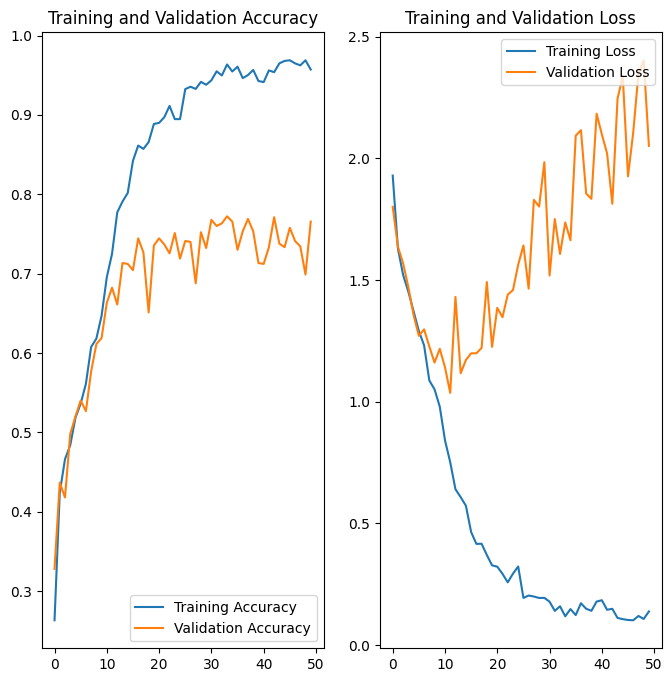

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?


In [ ]:
Accuracy on training data has increased by using Augmentor library

Model is still overfitting

The problem of overfitting can be solved by add more layer,neurons or adding dropout layers.

The Model can be further improved by tuning the hyperparameter